## Scraping

In [88]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import difflib
import time

In [64]:
transfer_urls = {"Premier" :    "http://www.transfermarkt.es/premier-league/transfers/wettbewerb/GB1",
                "Bundesliga":   "http://www.transfermarkt.es/bundesliga/transfers/wettbewerb/L1",
                "Serie A":      "http://www.transfermarkt.es/serie-a/transfers/wettbewerb/IT1",
                "Ligue 1":      "http://www.transfermarkt.es/ligue-1/transfers/wettbewerb/FR1",
                "La Liga":      "http://www.transfermarkt.es/primera-division/transfers/wettbewerb/ES1",
}


liga_urls = {"Premier" :    "http://www.transfermarkt.es/premier-league/startseite/wettbewerb/GB1",
            "Bundesliga":   "http://www.transfermarkt.es/bundesliga/startseite/wettbewerb/L1",
            "Serie A":      "http://www.transfermarkt.es/serie-a/startseite/wettbewerb/IT1",
            "Ligue 1":      "http://www.transfermarkt.es/ligue-1/startseite/wettbewerb/FR1",
            "La Liga":      "http://www.transfermarkt.es/laliga/startseite/wettbewerb/ES1",
}

In [86]:
df = pd.DataFrame(columns = ["target", "source", "Coste", "player"])

for liga in transfer_urls.keys():

    r = requests.get(liga_urls[liga],
                    headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})

    read_html_pandas_data = pd.read_html(r.text)

    for i in range(len(read_html_pandas_data)):
        try:
            teams_short = read_html_pandas_data[i]["Club.1"].to_list()
            teams_short.sort()

        except:
            pass

    time.sleep(2)

    r = requests.get(transfer_urls[liga],
                    headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})

    read_html_pandas_data = pd.read_html(r.text)

    soup = BeautifulSoup(r.text, "lxml")
    clubs =  soup.find_all("h2")

    clubs_list = []

    for club in clubs:
        try:
            club_name = difflib.get_close_matches(str(club.a.img).split('"')[1], 
                                                teams_short, 
                                                n=1 ,
                                                cutoff=0.45
                                                )[0]
            
            if club_name not in clubs_list:
                clubs_list.append(club_name)
        except:
            pass


    for i, club in enumerate(clubs_list):

        df_in = read_html_pandas_data[2*i +1]
        df_in.rename(columns={"Último club.1": "source", "Altas": "player"}, inplace= True)
        df_in["target"] = club

        df_out = read_html_pandas_data[2*i +2]
        df_out.rename(columns={"Nuevo club.1": "target",  "Bajas": "player"}, inplace= True)
        df_out["source"] = club

        df = pd.concat([df,df_in[["target", "source", "Coste", "player"]]])
        df = pd.concat([df,df_out[["target", "source", "Coste", "player"]]])

df



,target,source,Coste,player
0,Arsenal,West Ham,"116,60 mill. €",Declan RiceD. Rice
1,Arsenal,Chelsea,"75,00 mill. €",Kai HavertzK. Havertz
2,Arsenal,Ajax,"40,00 mill. €",Jurrien TimberJ. Timber
3,Arsenal,Brentford,"Coste de préstamo: 3,34 mill. €",David RayaD. Raya
4,Arsenal,Luton,Fin de préstamo 31/05/2024,Albert Sambi LokongaA. Lokonga
...,...,...,...,...
10,Athletic,Alavés,Fin de préstamo 30/06/2023,Asier VillalibreA. Villalibre
11,Real Madrid,Alavés,Fin de préstamo 30/06/2023,Antonio BlancoA. Blanco
12,Real Betis,Alavés,Fin de préstamo 30/06/2023,Rober GonzálezR. González
13,UD Almería,Alavés,Fin de préstamo 30/06/2023,Nikola MarasN. Maras


In [87]:
df.to_csv("data.csv")

## cleaning

In [132]:
df = df.drop_duplicates()
df = df[df["target"] != "Retirado"]

In [156]:
df_transfer = df[["target", "source", "player"]].groupby(["target", "source"]).count().reset_index()
df_transfer.rename(columns = {"player": "value"}, inplace = True)

## network

In [161]:
import networkx as nx
import matplotlib.pyplot as plt

from pyvis.network import Network
import community as community_louvain

In [157]:
G = nx.from_pandas_edgelist(df_transfer,
                            source = "source",
                            target = "target",
                            edge_attr = "value",
                            create_using = nx.Graph(),
                            )

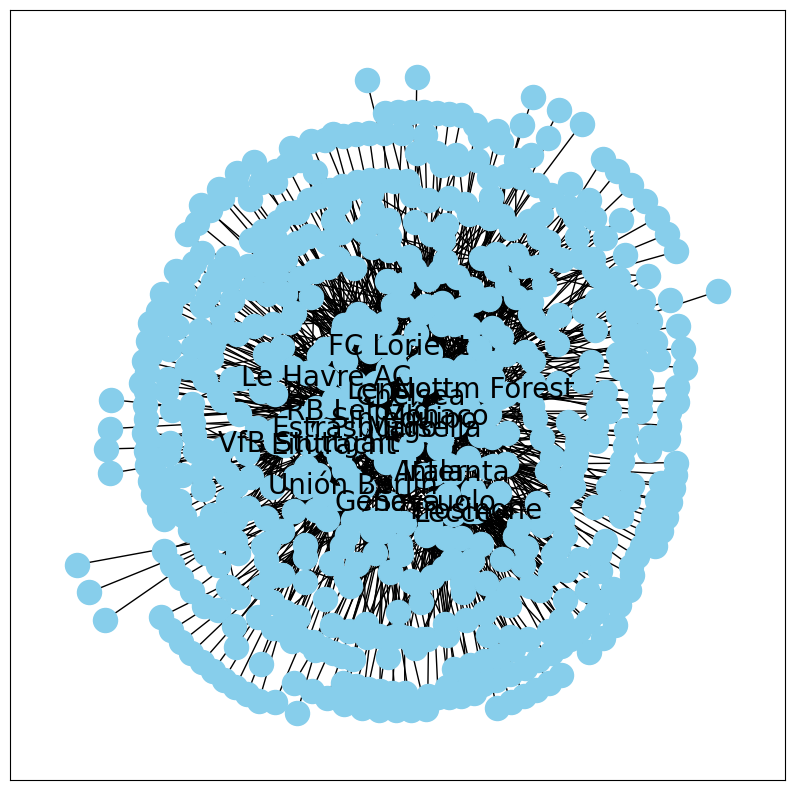

In [197]:
plt.figure(figsize = (10,10))
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(G, with_labels = False, node_color = "skyblue", edge_cmap = plt.cm.Blues, pos = pos)

sorted_nodes = sorted(node_degree.items(), key=lambda x:x[1], reverse=True)
labels_dict = dict(sorted_nodes[:19])

big_teams=[]
for node in labels_dict.items():
    big_teams.append(node[0])
big_teams

pos_large = {k: v for k, v in pos.items() if k in big_teams}


nx.draw_networkx_labels(G.subgraph(big_teams), pos_large, font_size=20)

plt.show()

## visualization

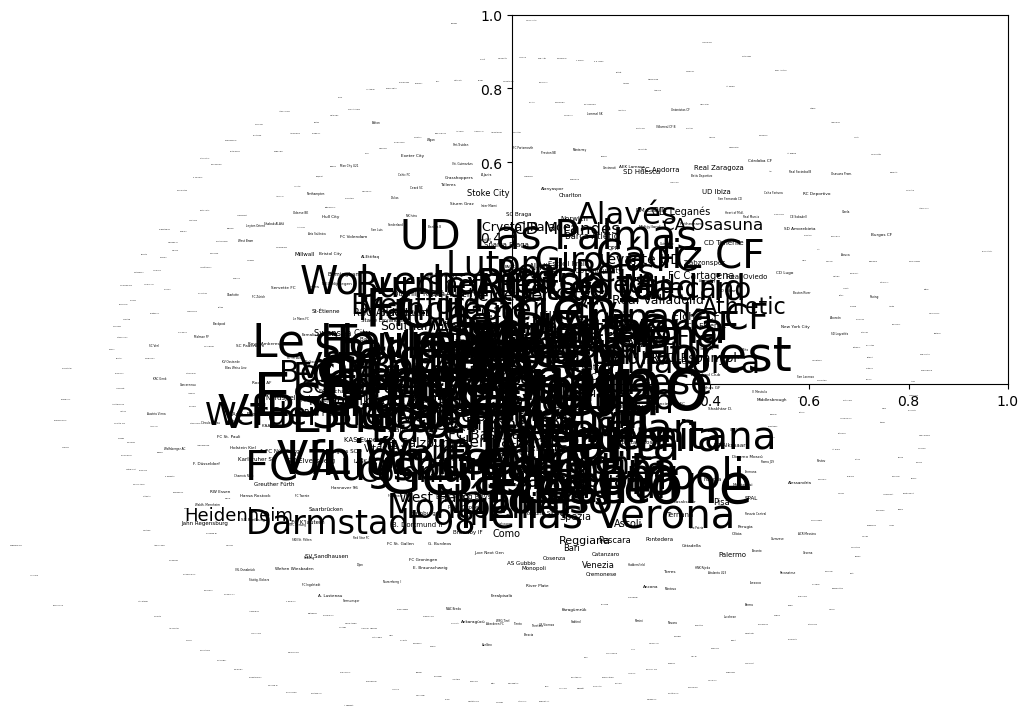

In [198]:
net = Network(notebook = False, width ="1000px", height = "720px", bgcolor = "#222222", font_color = "white")

node_degree = dict(G.degree) ###### revisar
centrality_dict = nx.degree_centrality(G)
closeness_dict = nx.closeness_centrality(G)
betweenness_dict = nx.betweenness_centrality(G)

#Community detection
communities = community_louvain.best_partition(G)

#set attributes

nx.set_node_attributes(G, node_degree, "size")
nx.set_node_attributes(G, centrality_dict, "degree_centrality")
nx.set_node_attributes(G, closeness_dict, "closeness_centrality")
nx.set_node_attributes(G, betweenness_dict, "betweenness_centrality")
nx.set_node_attributes(G, communities, "group")

net.repulsion()

net.from_nx(G)
net.show("transfer.html")